Bayesian optimization methods are commonly fueled by Gaussian process regressors (GP) due to their excellent uncertainty estimates. However, GPs do not natively handle categorical data. Gradient-boosted decision tree (GBDT) on the other handle categorical data well but do not natively support uncertainty estimates. Thebelt et al. propose to establish uncertainty for GBDTs using a distance measure:
* [Thebelt et al.: Multi-Objective Constrained Optimization for Energy Applications via Tree Ensembles. *arXiv*, **2021**](https://arxiv.org/pdf/2111.03140)

Specifically, they propose use of the so-called *goodall4* metric originally formulated by Boriah et al.:
* [Boriah et al.: Similarity Measures for Categorical Data: A Comparative Evaluation. *Proceedings of the 2008 SIAM International Conference on Data Mining*, **2008**, 243–254](https://epubs.siam.org/doi/epdf/10.1137/1.9781611972788.22)

In this short notebook, we are going to implement this *goodall4* metric and have a quick peak. For this, we are using a dataset we already used before in this repo and that is described [here](https://chemrxiv.org/engage/chemrxiv/article-details/62f6966269f3a5df46b5584b). This dataset has 3 categorical features: ligand, base and solvent. So, let's get that dataset:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
plt.rcParams["figure.dpi"] = 300

cat_cols = ["ligand", "base", "solvent"]
df = pd.read_csv("https://raw.githubusercontent.com/doyle-lab-ucla/edboplus/main/examples/publication/Suzuki/data/dataset_B2_DFT_clean.csv")[cat_cols]
df.loc[:, "base"] = df.loc[:, "base"].astype("str")


def set_cats(df, dic_cats):
    for col, cats in dic_cats.items():
        df[col] = pd.Categorical(df[col].values, categories=cats, ordered=False)
    return df


dic_cats = {}
for col in cat_cols:
    dic_cats[col] = df[col].unique().tolist()

df = set_cats(df, dic_cats)
df.head(5)

,ligand,base,solvent
0,P(tBu)3,NaOH(aq.),MeOH
1,P(tBu)3,s. NaHCO3(aq.),MeOH
2,P(tBu)3,CsF(aq.),MeOH
3,P(tBu)3,1M K3PO4(aq.),MeOH
4,P(tBu)3,KOH(aq.),MeOH


Now, we sample 11 rows from this dataset. Note that row 11 is a repeat of row 1.

In [2]:
df_sample = df.sample(10, random_state=0).reset_index(drop=True)
df_sample = pd.concat([df_sample, df_sample.iloc[:1, :]], ignore_index=True)
df_sample

,ligand,base,solvent
0,P(tBu)3,KOAc,MeOH
1,P(Ph)3,KOH(aq.),THF
2,XPhos,1M K3PO4(aq.),MeOH
3,P(Ph)3,Cs2CO3(aq.),MeCN
4,SPhos,KOAc,THF
5,SPhos,KOH(aq.),THF
6,P(o-Tol)3,KOAc,THF
7,dtbpf,nan,DMF
8,AmPhos,KOH(aq.),DMF
9,AmPhos,CsF(aq.),DMF


Now, we are calculating the distance matrix of these 11 samples based on the *goodall4* metric. Before we can use our *goodall4* function, we have to encode our categories as ordinals:

In [3]:
class OrdinalEncoder:       
    def encode(self, df, dic_cats):
        df_ = deepcopy(df)
        for col, cats in dic_cats.items():
            df_[col] = df_[col].cat.codes
        return df_


def goodall4(x):
    freq = np.apply_along_axis(lambda x: np.bincount(x)[x], 0, x)
    freq = (freq * (freq - 1)) / (x.shape[0] * (x.shape[0] - 1))
    dist = np.zeros((x.shape[0], x.shape[0]))
    r, c = np.triu_indices(x.shape[0], 1)
    dist[c, r] = 1 - (freq[r, :] * (x[r] == x[c])).sum(axis=1) / x.shape[1]
    dist = dist + dist.T - np.diag(np.diag(dist))
    return dist


encoder = OrdinalEncoder()
df_sample_encoded = encoder.encode(df_sample, dic_cats)

dist_matrix = goodall4(df_sample_encoded.values)

Let's visualize the distance matrix:

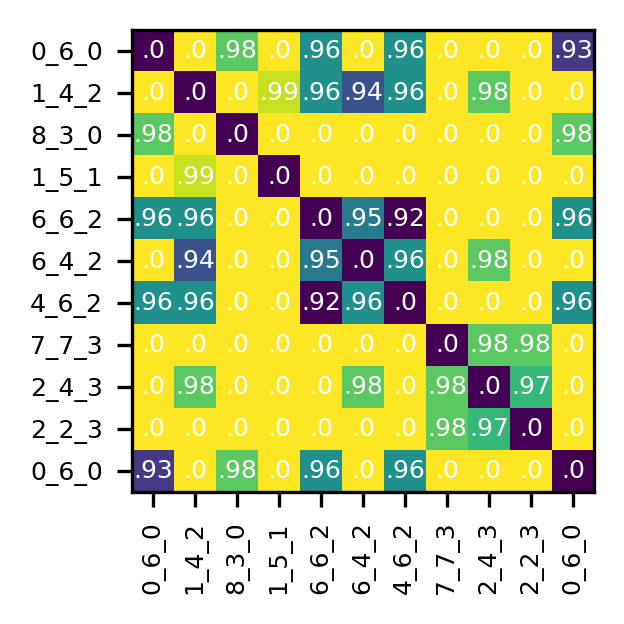

In [4]:
codes = (df_sample_encoded["ligand"].astype(str) + "_" + 
         df_sample_encoded["base"].astype(str) + "_" + 
         df_sample_encoded["solvent"].astype(str))

fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.imshow(dist_matrix, vmin=dist_matrix[dist_matrix != 0].min(), vmax=1)
ax.set_xticks(np.arange(0, 11))
ax.set_xticklabels(labels=codes, rotation=90, fontsize=6)
ax.set_yticks(np.arange(0, 11))
ax.set_yticklabels(labels=codes, rotation=0, fontsize=6)

for i in range(11):
    for j in range(11):
        text = ax.text(
            j, i, f"{str(dist_matrix[i, j])[1:4]}",
            ha="center", va="center", color="w", fontsize=6)
plt.show()

Row 1 & 11 highlight one counter-intuitive aspect of the *goodall4* metric. Even though these two rows are identically, their distance is not 0.